tgb - 5/20/2019 - The goal is to study the relationship between precipitation and column water vapor using neural networks. Because neural networks are fast, non-linear models of physical relationships, they can capture behavior that would otherwise necessit computationally expensive simulations. Three steps:  
1) Reproduce the tropical Precipitation - Column Water Vapor curve with neural networks  
2) Capture variability of temperature and water vapor using principle component analysis  
3) Feed the main modes of variability to the neural network to see which modes of variability reproduce the P-Q relationship

# 1) Load CBRAIN modules and aquaplanet dataset

## 1.1) Load CBRAIN modules

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


Load coordinates

In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

## 1.2) Evaluate P-Q relationship from data

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

Load the NNLU network as an example

In [6]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/NNA0.01.h5'
NN['NNA0.01'] = load_model(path,custom_objects=dict_lay)
md['NNA0.01'] = ModelDiagnostics(NN,config_fn,data_fn)
# NNL0.01
path = TRAINDIR+'HDF5_DATA/NNL0.01.h5'
NN['NNL0.01'] = load_model(path,custom_objects=dict_lay)
md['NNL0.01'] = ModelDiagnostics(NN,config_fn,data_fn)
# Jordan network
path = TRAINDIR+'HDF5_DATA/JordanNNAU01.h5'
NN['J01'] = load_model(path,custom_objects=dict_lay)
md['J01'] = ModelDiagnostics(NN,config_fn,data_fn)

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
NNa = ['NNA0.01','NNL0.01','J01']

In [31]:
# User's choice
latTROP = [-20,20]
Nt = 100
iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))

P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# Initialization
CWVtrop = np.zeros((len(iTROP[0]),len(coor.lon),1))
QVtrop = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
Ttrop = np.copy(QVtrop)
PRECtrop = np.zeros((len(iTROP[0]),len(coor.lon),1))

PREC_NN = {}
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),1))

for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md[NNname] # Reference model diagnostic object
    # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
    X, truth = m.valid_gen[itime]
    PRECIP = (np.sum(truth.values[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
    # 2) Water vapor
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)[iTROP,:,:]
    QVtrop = np.concatenate((QVtrop,np.expand_dims(QVgeo[0,:,:,:],axis=3)),axis=3)
    CWVgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*QV/G,axis=1),axis=1))
    CWVtrop = np.concatenate((CWVtrop,CWVgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # 3) Precipitation
    PRECgeo = m.reshape_ngeo(PRECIP)
    PRECtrop = np.concatenate((PRECtrop,PRECgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # 4) Temperature
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    Tgeo = m.reshape_ngeo(T.values)[iTROP,:,:]
    Ttrop = np.concatenate((Ttrop,np.expand_dims(Tgeo[0,:,:,:],axis=3)),axis=3)
    # 5) Precipitation from NN prediction
    for iNN,NNname in enumerate(NNa):
        pred = md[NNname].model[NNname].predict_on_batch(X)
        PRECIP_NN = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
        PREC_NN[NNname] = np.concatenate((
            PREC_NN[NNname],
            md[NNname].reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:]),
            axis=2)

# Remove initial zero
QVtrop = QVtrop[:,:,:,1:]
Ttrop = Ttrop[:,:,:,1:]
CWVtrop = CWVtrop[:,:,1:]
PRECtrop = PRECtrop[:,:,1:]
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]

In [32]:
#PREC_NN['NNA0.01']

In [71]:
# import matplotlib.pyplot as plt
# plt.scatter(CWVtrop,PRECtrop,color='r')
# plt.scatter(CWVtrop,PREC_NN,color='b')

In [33]:
# Histogram parameters
Nbin = 100
CWVmin = 20
CWVmax = 70

In [36]:
CWVm = np.zeros((Nbin-1,1))
Pm = np.copy(CWVm)
PNNm = {}
for iNN,NNname in enumerate(NNa):
    PNNm[NNname] = np.copy(Pm)

for ibin,edge in enumerate(np.linspace(CWVmin,CWVmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtrop,weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        Pm[ibin-1] = np.average(PRECtrop,weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        for iNN,NNname in enumerate(NNa):
            PNNm[NNname][ibin-1] = np.average(
                PREC_NN[NNname],
                weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        
    edge_left = edge

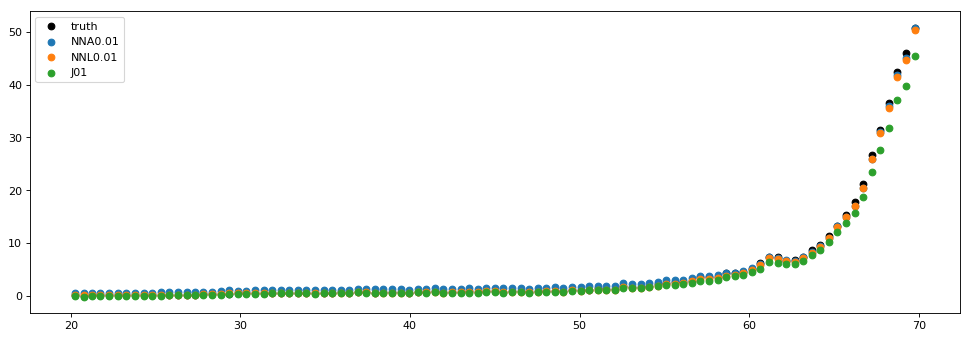

In [39]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(CWVm,Pm,color='k',label='truth')
for iNN,NNname in enumerate(NNa):
    plt.scatter(CWVm,PNNm[NNname],label=NNname)
plt.legend()

## 1.3 Build conditional P-Q relationship from data  
tgb - 5/20/2019 - Not very convenient in Python... Maybe best to accumulate and calculate conditional statistics at the end

In [38]:
# # Histogram parameters
# Nbin = 100
# CWVmin = 0
# CWVmax = 80

In [40]:
# User's choice
# latTROP = [-20,20]
# iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))

# P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# # Allocate histogram array
# CWVhist = np.zeros(Nbin)
# Phist = np.copy(CWVhist)
# P_NNhist = np.copy(Phist)

# for itime in range(2):
#     print('itime=',itime)
#     # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
#     X, truth = md.valid_gen[itime]
#     PRECIP = (np.sum(truth.values[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
#     pred = md.model.predict_on_batch(X)
#     PRECIP_NN = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
#     # 2) Calculate column water vapor 
#     QV = md.valid_gen.input_transform.inverse_transform(X)[:,md.get_input_var_idx('QBP')]
#     CWVgeo = md.reshape_ngeo(np.expand_dims(np.sum(md.dP(itime)*QV/G,axis=1),axis=1))
#     # 3) Calculate true and predicted histogram
#     # True column water vapor histogram
#     average_speed = numpy.average(speeds, weights=(speeds > 0))
#     hist,edges = np.histogram(CWVgeo[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     CWVhist += hist
#     hist,edges = np.histogram(md.reshape_ngeo(PRECIP)[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     Phist += hist
#     hist,edges = np.histogram( md.reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     P_NNhist += hist

# bins = 0.5*(edges[1:]+edges[:-1])

itime= 0
itime= 1


In [42]:
# A = CWVgeo[iTROP,:,:][0,:,:,:]
# A.flatten().shape
# B = A.flatten()
# CWVm = np.average(B, weights=((B>0)*(B<25)))

# 2) Principle component analysis of temperature and water vapor

## 2.1) Start with water vapor PCA: We will use this PCA as our main basis

tgb - 5/20/2019 - Uses the answer of https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [48]:
QVtrop.shape
H = np.concatenate((L_V*QVtrop,C_P*Ttrop),axis=2)

In [50]:
Hswap = np.swapaxes(H,2,3)
Hswap.shape

(14, 128, 100, 60)

In [51]:
S = Hswap.shape
Htopca = Hswap.reshape(S[0]*S[1]*S[2],S[3])
Htopca.shape

(179200, 60)

tgb - 5/20/2019 - Using https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca

In [52]:
pca = decomposition.PCA(n_components=60)
pca.fit(Htopca)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [67]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_[1]

[6.63140809e-01 7.37258937e-02 6.14208744e-02 5.79297014e-02
 3.43026701e-02 1.47907194e-02 1.27583182e-02 1.10923544e-02
 8.70883286e-03 7.84014175e-03 7.17892269e-03 6.12692473e-03
 5.78602218e-03 4.62277698e-03 4.14341640e-03 3.87049875e-03
 3.18697802e-03 2.81618763e-03 2.26620376e-03 1.80671564e-03
 1.73669645e-03 1.44883636e-03 1.32681914e-03 1.19906727e-03
 1.14713657e-03 8.27510642e-04 7.01986130e-04 6.07239076e-04
 5.59653604e-04 5.14325993e-04 4.26424408e-04 3.97388140e-04
 3.10613672e-04 2.62003682e-04 2.13469458e-04 1.67370948e-04
 1.49753060e-04 1.40283811e-04 1.25632428e-04 6.58496245e-05
 6.27866926e-05 3.61863708e-05 2.67854001e-05 1.22904673e-05
 8.48174254e-06 5.94556114e-06 2.33037063e-06 1.86875175e-06
 2.65963904e-07 3.18580173e-08 3.68393116e-09 4.13991899e-10
 1.17177885e-10 4.19896859e-11 1.85007405e-11 8.93420589e-12
 6.89204230e-12 3.38118579e-12 1.58375097e-12 3.40729392e-13]


0.0737258936524773

In [54]:
pca.components_.shape

(60, 60)

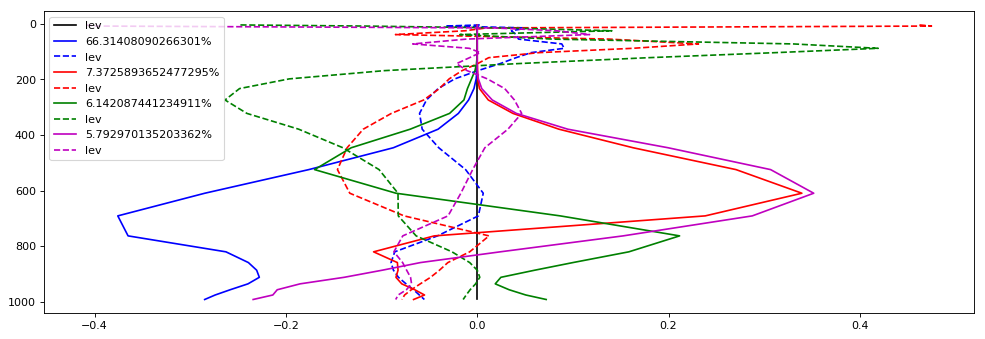

In [73]:
COL = ['b','r','g','m']

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
# Plot moisture and temperature modes separately
plt.plot(0*coor.lev**0,coor.lev,color='k')
for icom in range(4):
    plt.plot(pca.components_[icom,:30],coor.lev,color=COL[icom],
             label=(str(100*pca.explained_variance_ratio_[icom])+'%'))
    plt.plot(pca.components_[icom,30:],coor.lev,color=COL[icom],linestyle='--')
plt.legend()
plt.gca().invert_yaxis()

## 2.2) Vary mean water vapor and temperature profile using PCA